In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/archive.zip"

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/lgg-mri-segmentation/kaggle_3m'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_11_mask.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_22.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_4_mask.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_19.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_1.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_23_mask.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_27.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_16.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_20_mask.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_20.tif
/content/lgg-mri-segmentation/kaggle

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline


In [ ]:
class Config:
    # data preprocessing
    data_dir = '/content/lgg-mri-segmentation/kaggle_3m'
    logdir = 'logdir'
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32

    # model setup
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1

    # training
    seed = 21
    learning_rate = 0.01
    epochs = 30
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
def plot_example(idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[1].imshow(mask)
    ax[1].set_title('Mask')
    plt.show()

In [ ]:
import os

# /kaggle_3m/ 디렉토리의 내용 출력
dir_path = '/content/kaggle_3m/TCGA_FG_A4MT_20020212'
if os.path.exists(dir_path):
    print("Directory exists. Listing contents:")
    print(os.listdir(dir_path))
else:
    print("Directory does not exist.")


Directory exists. Listing contents:
['TCGA_FG_A4MT_20020212_22.tif', 'TCGA_FG_A4MT_20020212_7_mask.tif', 'TCGA_FG_A4MT_20020212_37.tif', 'TCGA_FG_A4MT_20020212_14_mask.tif', 'TCGA_FG_A4MT_20020212_5.tif', 'TCGA_FG_A4MT_20020212_49.tif', 'TCGA_FG_A4MT_20020212_31_mask.tif', 'TCGA_FG_A4MT_20020212_33.tif', 'TCGA_FG_A4MT_20020212_22_mask.tif', 'TCGA_FG_A4MT_20020212_3.tif', 'TCGA_FG_A4MT_20020212_36.tif', 'TCGA_FG_A4MT_20020212_44_mask.tif', 'TCGA_FG_A4MT_20020212_40.tif', 'TCGA_FG_A4MT_20020212_12.tif', 'TCGA_FG_A4MT_20020212_35_mask.tif', 'TCGA_FG_A4MT_20020212_2.tif', 'TCGA_FG_A4MT_20020212_35.tif', 'TCGA_FG_A4MT_20020212_46.tif', 'TCGA_FG_A4MT_20020212_27.tif', 'TCGA_FG_A4MT_20020212_50_mask.tif', 'TCGA_FG_A4MT_20020212_10_mask.tif', 'TCGA_FG_A4MT_20020212_21.tif', 'TCGA_FG_A4MT_20020212_8_mask.tif', 'TCGA_FG_A4MT_20020212_41_mask.tif', 'TCGA_FG_A4MT_20020212_48_mask.tif', 'TCGA_FG_A4MT_20020212_42_mask.tif', 'TCGA_FG_A4MT_20020212_5_mask.tif', 'TCGA_FG_A4MT_20020212_48.tif', 'TCGA_FG

In [ ]:
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap='gray')
    if title:
        fig.suptitle(title)
    plt.show()

In [ ]:
def plot_predictions(model, idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])

    img = Image.open(img_path)
    mask = Image.open(mask_path)

    tensor_img, tensor_mask = eval_transforms((img, mask))
    tensor_img = tensor_img.unsqueeze(0).to(Config.device)

    model.eval()
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1, 2, 0)).squeeze()
        rounded = np.round(pred)

    plot_images = {'Image': img,
                   'Mask': mask,
                   'Predicted Mask': pred,
                   'Predicted Rounded Mask': rounded}

    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
    plt.show()

In [ ]:
set_seed(Config.seed)

In [ ]:
dirs, images, masks = [], [], []
for root, folders, files in os.walk(Config.data_dir):
    for file in files:
        # save only images with corresponding masks
        if 'mask'in file:
            dirs.append(root.replace(Config.data_dir, '/content/kaggle_3m/'))
            masks.append(file)
            images.append(file.replace('_mask', ''))

PathDF = pd.DataFrame({'directory': dirs, 'images': images, 'masks': masks})
PathDF.head()

,directory,images,masks
0,/content/kaggle_3m//TCGA_DU_7300_19910814,TCGA_DU_7300_19910814_35.tif,TCGA_DU_7300_19910814_35_mask.tif
1,/content/kaggle_3m//TCGA_DU_7300_19910814,TCGA_DU_7300_19910814_29.tif,TCGA_DU_7300_19910814_29_mask.tif
2,/content/kaggle_3m//TCGA_DU_7300_19910814,TCGA_DU_7300_19910814_5.tif,TCGA_DU_7300_19910814_5_mask.tif
3,/content/kaggle_3m//TCGA_DU_7300_19910814,TCGA_DU_7300_19910814_10.tif,TCGA_DU_7300_19910814_10_mask.tif
4,/content/kaggle_3m//TCGA_DU_7300_19910814,TCGA_DU_7300_19910814_23.tif,TCGA_DU_7300_19910814_23_mask.tif


In [ ]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction/train2rest

train_df, rest = train_test_split(
    PathDF, random_state=Config.seed,
    test_size=train2rest
)

test_df, valid_df = train_test_split(
    rest, random_state=Config.seed,
    test_size=test2valid
)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])

Train: 2946
Valid: 590
Test: 393


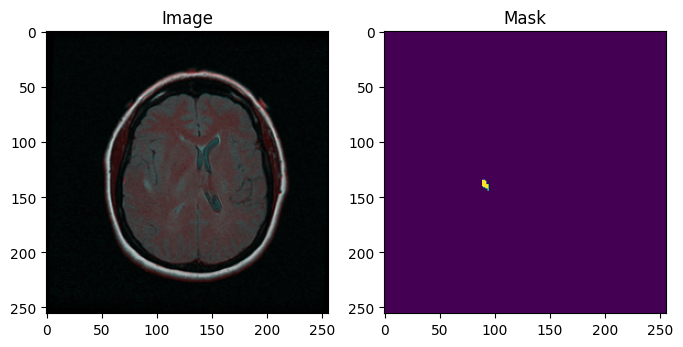

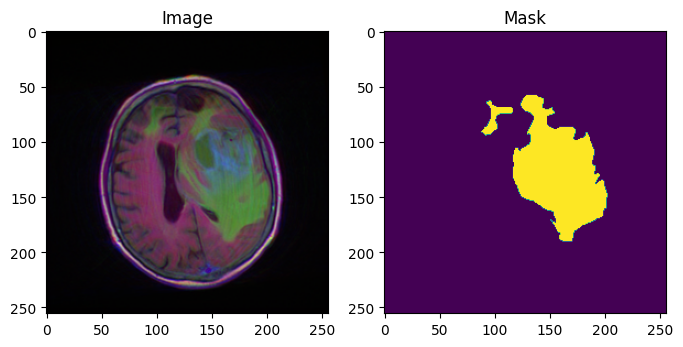

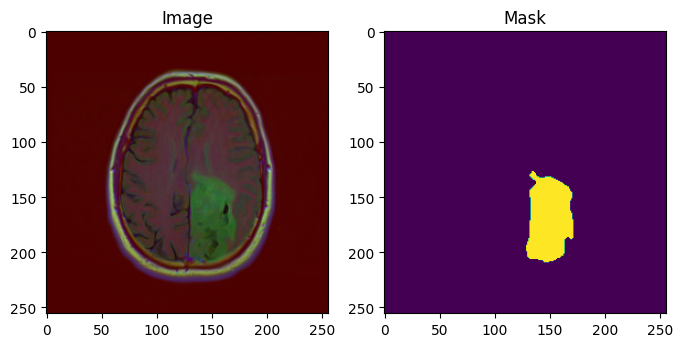

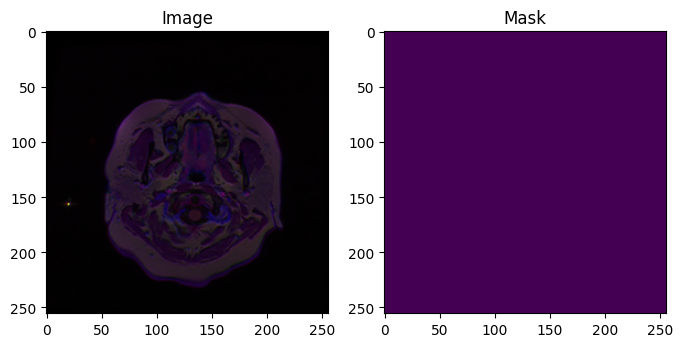

In [ ]:
plot_example(20)
plot_example(122)
plot_example(241)
plot_example(346)

In [ ]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]

    def __getitem__(self, idx):
        base_path = os.path.join(Config.data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        sample = (image, mask)
        # apply the same transform on both image and a mask
        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
class PairedRandomHorizontalFlip():
    """Custom transform for horizontal flipping"""
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        """
        Randomly flips both of the images

        Arguments:
        sample - tuple, image and segmentation mask

        Returns:
        (img, mask) - tuple, transformed sample
        """
        img, mask = sample
        if np.random.random() < self.prob:
            img, mask = TF.hflip(img), TF.hflip(mask)
        return img, mask


In [ ]:
class PairedRandomAffine():
    """
    Randomly applies affine transformation
    on both of the images
    """
    def __init__(self, degrees=None, translate=None, scale_ranges=None, shears=None):

        self.params = {
            'degrees': degrees,
            'translate': translate,
            'scale_ranges': scale_ranges,
            'shears': shears
        }

    def __call__(self, sample):
        img, mask = sample
        w, h = img.size
        # extract parameters from trasnforms.RandomAffine
        angle, translations, scale, shear = transforms.RandomAffine.get_params(self.params['degrees'], self.params['translate'], self.params['scale_ranges'], self.params['shears'], (w,h))
        # apply TF.affine using fixed parameters
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        return img, mask

In [ ]:
class PairedToTensor():
    """
    Convert ndarrays in sample to Tensors.
    """
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask

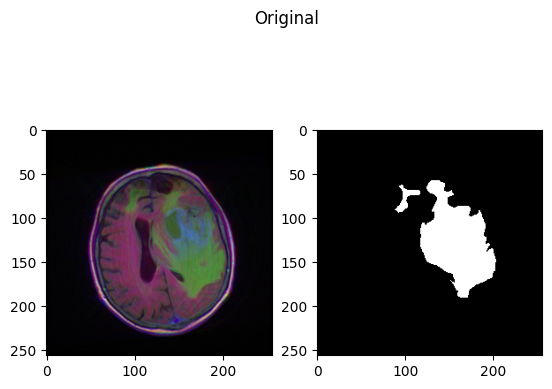

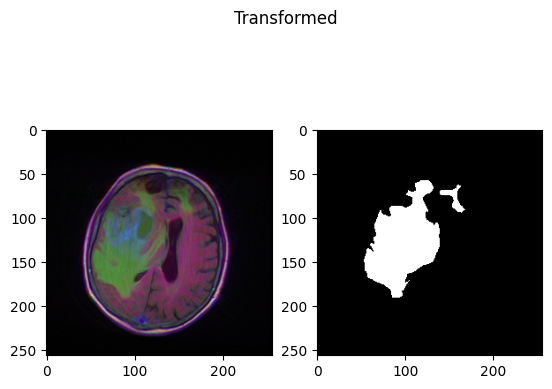

In [ ]:
dataset = MRI_Dataset(test_df)
sample = dataset[122]
transform = PairedRandomHorizontalFlip(prob=1)
show_sample(sample, title='Original')
show_sample(transform(sample), title='Transformed')

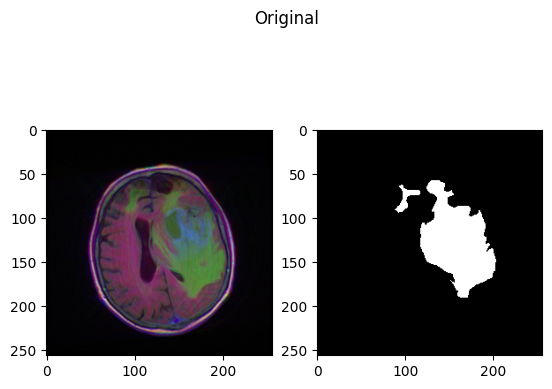

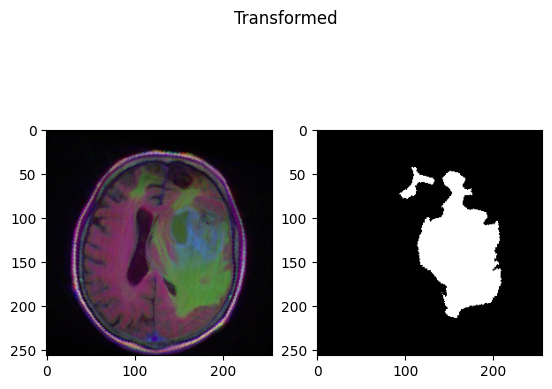

In [ ]:
transform = PairedRandomAffine(
    degrees=(15, 15),
    scale_ranges=(1.2, 1.2)
) # for testing purposes we fix degrees and scale to a constant number
show_sample(sample, 'Original')
show_sample(transform(sample), 'Transformed')

In [ ]:
train_transforms = transforms.Compose([
    PairedRandomHorizontalFlip(),
    PairedRandomAffine(
        degrees=(-15, 15),
        translate=(0.1, 0.1),
        scale_ranges=(0.8, 1.2)
    ),
    PairedToTensor()
])
eval_transforms = PairedToTensor()

train_data = MRI_Dataset(train_df, transform=train_transforms)
valid_data = MRI_Dataset(valid_df, transform=eval_transforms)
test_data = MRI_Dataset(test_df, transform=eval_transforms)

train_loader = DataLoader(train_data, batch_size=Config.train_batch, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=Config.test_batch, shuffle=False, num_workers=2)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
         )
    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2,2),
            DoubleConv(in_ch, out_ch)
         )
    def forward(self, x):
        x = self.mpconv(x)
        return x

In [ ]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, csv_path):
        super(UNet, self).__init__()
        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, num_classes)

        # CSV 파일 읽기 및 feature scaling
        df = pd.read_csv(csv_path)

        # Label Encoding or One-Hot Encoding
        self.encoders = {}
        for column in df.columns:
            if df[column].dtype == object:
                le = LabelEncoder()
                df[column] = le.fit_transform(df[column])
                self.encoders[column] = le

        self.scaler = StandardScaler()
        self.csv_features = self.scaler.fit_transform(df.drop(columns=['death01']).values)
        self.csv_features = torch.tensor(self.csv_features, dtype=torch.float32)

        # Contracting path의 feature 크기 계산
        with torch.no_grad():
            x_dummy = torch.randn(1, in_channels, 256, 256)
            x1 = self.inc(x_dummy)
            print('x1 shape:', x1.shape)
            x2 = self.down1(x1)
            print('x2 shape:', x2.shape)
            x3 = self.down2(x2)
            print('x3 shape:', x3.shape)
            x4 = self.down3(x3)
            print('x4 shape:', x4.shape)
            x5 = self.down4(x4)
            print('x5 shape:', x5.shape)
            feature_dim = x5.view(x5.size(0), -1).size(1)

        # Classification layer
        self.fc1 = nn.Linear(feature_dim + self.csv_features.shape[1], 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, csv_idx):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Contracting path 끝나는 지점에서 feature 추출
        feature = x5.view(x5.size(0), -1)
        print('feature shape:', feature.shape)

        # CSV 데이터와 결합
        csv_data = self.csv_features[csv_idx].unsqueeze(0)
        print('csv_data shape:', csv_data.shape)
        combined_features = torch.cat((feature, csv_data), dim=1)
        print('combined_features shape:', combined_features.shape)

        # Classification layer 통과
        x_class = self.fc1(combined_features)
        x_class = nn.ReLU()(x_class)
        x_class = self.fc2(x_class)
        x_class = self.sigmoid(x_class)

        # Expanding path
        x = self.up1(x5, x4)
        print('x after up1 shape:', x.shape)
        x = self.up2(x, x3)
        print('x after up2 shape:', x.shape)
        x = self.up3(x, x2)
        print('x after up3 shape:', x.shape)
        x = self.up4(x, x1)
        print('x after up4 shape:', x.shape)
        x = self.outc(x)
        print('x final output shape:', x.shape)

        return x, x_class

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
csv_path = '/content/drive/MyDrive/data.csv'
model = UNet(in_channels=3, num_classes=1, csv_path=csv_path)

# 예시 입력 데이터
image_input = torch.randn(1, 3, 256, 256)  # 이미지 입력
csv_index = 1   # CSV 파일에서 사용할 행 인덱스
# Forward pass
segmentation_output, classification_output = model(image_input, csv_index)

x1 shape: torch.Size([1, 64, 256, 256])
x2 shape: torch.Size([1, 128, 128, 128])
x3 shape: torch.Size([1, 256, 64, 64])
x4 shape: torch.Size([1, 512, 32, 32])
x5 shape: torch.Size([1, 512, 16, 16])
feature shape: torch.Size([1, 131072])
csv_data shape: torch.Size([1, 17])
combined_features shape: torch.Size([1, 131089])
x after up1 shape: torch.Size([1, 256, 32, 32])
x after up2 shape: torch.Size([1, 128, 64, 64])
x after up3 shape: torch.Size([1, 64, 128, 128])
x after up4 shape: torch.Size([1, 64, 256, 256])
x final output shape: torch.Size([1, 1, 256, 256])


In [ ]:
def train_loop(model, optimizer, criterion, train_loader, device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    return running_loss

In [ ]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1,
        'loss':running_loss}


In [ ]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=Config.device,
          num_epochs=Config.epochs,
          valid_loss_min=np.inf):

    # Define the path to save the model in Google Drive
    save_path = '/content/drive/MyDrive/UNet.pt'

    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)

        # save the model if validation loss has decreased
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = metrics["loss"]


In [ ]:
set_seed(Config.seed)
model = UNet(Config.input_ch, Config.output_ch).to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
criterion = nn.BCELoss()
train(model, optimizer, criterion, train_loader, valid_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 1 TrainLoss: 0.05334 ValidLoss: 0.03746 ACC: 0.98923 F1: 0.000


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 2 TrainLoss: 0.03041 ValidLoss: 0.02956 ACC: 0.99082 F1: 0.348


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 3 TrainLoss: 0.02698 ValidLoss: 0.03441 ACC: 0.99052 F1: 0.252


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1cdf2ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self.

Epoch: 4 TrainLoss: 0.02580 ValidLoss: 0.03503 ACC: 0.99042 F1: 0.194


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 5 TrainLoss: 0.02180 ValidLoss: 0.02290 ACC: 0.99339 F1: 0.577


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 6 TrainLoss: 0.01959 ValidLoss: 0.02328 ACC: 0.99185 F1: 0.631


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 7 TrainLoss: 0.01952 ValidLoss: 0.01739 ACC: 0.99420 F1: 0.684


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 8 TrainLoss: 0.01808 ValidLoss: 0.01904 ACC: 0.99383 F1: 0.605


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 9 TrainLoss: 0.01772 ValidLoss: 0.02063 ACC: 0.99309 F1: 0.664


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 10 TrainLoss: 0.01689 ValidLoss: 0.01954 ACC: 0.99322 F1: 0.666


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 11 TrainLoss: 0.01613 ValidLoss: 0.01830 ACC: 0.99354 F1: 0.679


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 12 TrainLoss: 0.01647 ValidLoss: 0.01586 ACC: 0.99442 F1: 0.686


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 13 TrainLoss: 0.01563 ValidLoss: 0.01587 ACC: 0.99455 F1: 0.675


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 14 TrainLoss: 0.01513 ValidLoss: 0.01438 ACC: 0.99480 F1: 0.726


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 15 TrainLoss: 0.01496 ValidLoss: 0.01737 ACC: 0.99402 F1: 0.694


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 16 TrainLoss: 0.01461 ValidLoss: 0.01397 ACC: 0.99490 F1: 0.698


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 17 TrainLoss: 0.01469 ValidLoss: 0.01565 ACC: 0.99468 F1: 0.703


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 18 TrainLoss: 0.01432 ValidLoss: 0.01662 ACC: 0.99419 F1: 0.635


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 19 TrainLoss: 0.01368 ValidLoss: 0.01217 ACC: 0.99515 F1: 0.751


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 20 TrainLoss: 0.01317 ValidLoss: 0.01204 ACC: 0.99525 F1: 0.743


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 21 TrainLoss: 0.01212 ValidLoss: 0.01321 ACC: 0.99500 F1: 0.716


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 22 TrainLoss: 0.01273 ValidLoss: 0.01259 ACC: 0.99508 F1: 0.707


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 23 TrainLoss: 0.01265 ValidLoss: 0.01360 ACC: 0.99456 F1: 0.734


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 24 TrainLoss: 0.01204 ValidLoss: 0.01151 ACC: 0.99530 F1: 0.730


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 25 TrainLoss: 0.01234 ValidLoss: 0.01321 ACC: 0.99484 F1: 0.691


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 26 TrainLoss: 0.01100 ValidLoss: 0.01021 ACC: 0.99594 F1: 0.802


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 27 TrainLoss: 0.01058 ValidLoss: 0.01230 ACC: 0.99512 F1: 0.707


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 28 TrainLoss: 0.01206 ValidLoss: 0.01009 ACC: 0.99601 F1: 0.818


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 29 TrainLoss: 0.01017 ValidLoss: 0.01049 ACC: 0.99580 F1: 0.781


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)


Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Iterating over evaluation data:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
<ipython-input-18-dabaefe3b351>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img, mask =  torch.FloatTensor(im

Epoch: 30 TrainLoss: 0.01052 ValidLoss: 0.01084 ACC: 0.99589 F1: 0.780


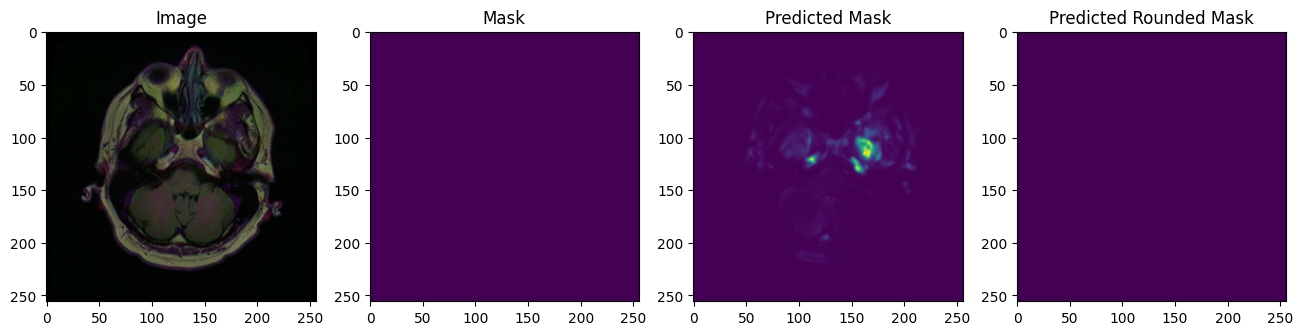

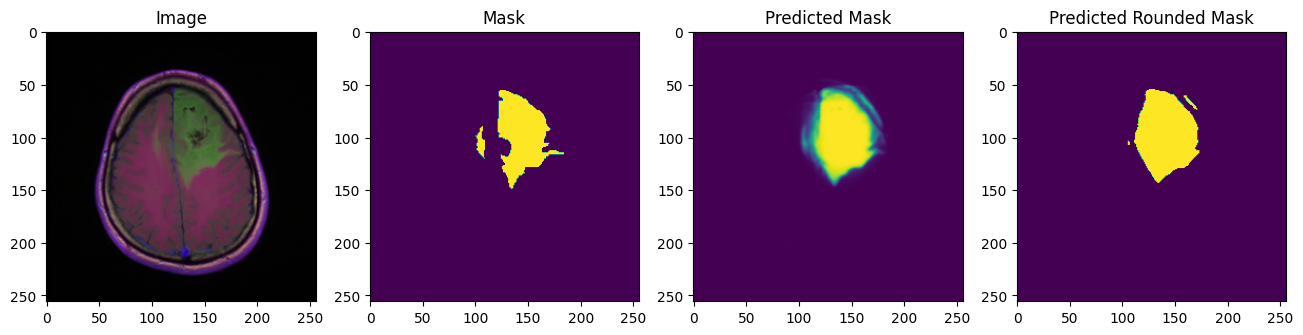

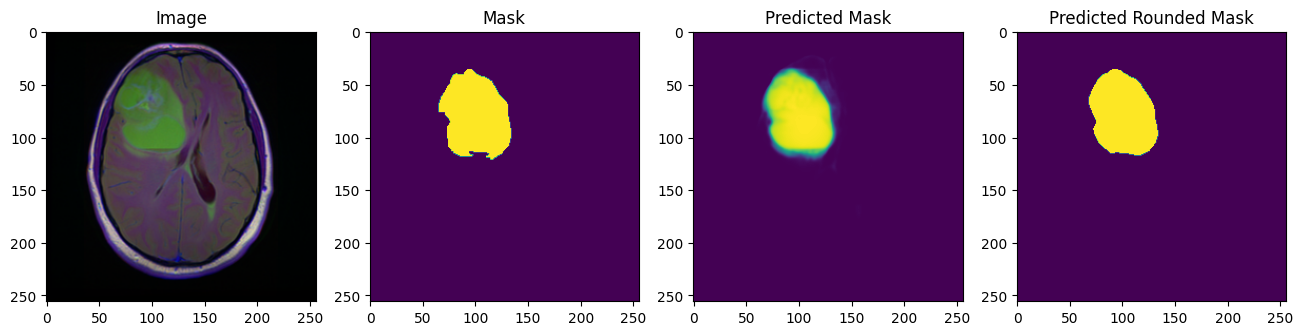

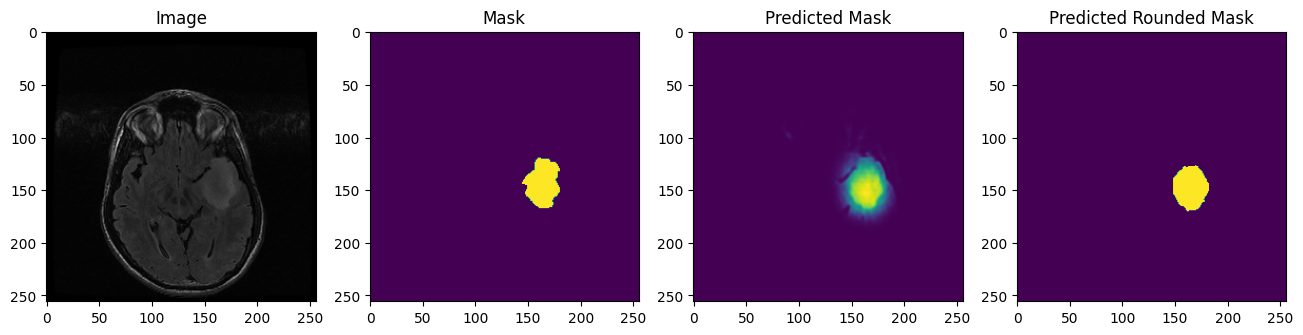

In [ ]:
plot_predictions(model, 59)
plot_predictions(model, 125)
plot_predictions(model, 240)
plot_predictions(model, 346)